In [1]:
#the purpose here is to simply plot and compute a linear regression of each cluster binding intensity with 

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
import re
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline

/home/sam/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
#read in the master dataframe
df = pd.read_csv('hnM_DMSO_TAM_master_dataframe_gene_expression_normalized',sep='\t')

In [3]:
df.head()

,cluster_id,chrom,start,end,ens_gene,blank,strand,hnM_DMSO,hnM_TAM,hnM_DMSO_1,...,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,hnM_DMSO_clip_gene_fpkm_norm_1,hnM_TAM_clip_gene_fpkm_norm_1,hnM_DMSO_clip_gene_tpm_norm,hnM_TAM_clip_gene_tpm_norm,hnM_DMSO_clip_gene_tpm_norm_1,hnM_TAM_clip_gene_tpm_norm_1,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm,log2ratio_hnM_TAM_DMSO_gene_tpm_norm
0,chr1:251624-251660,chr1,251624,251660,ENSG00000228463,0,-,5.05088,0.000000,6.05088,...,4.853055,0.000000,5.853055,1.000000,1.785813,0.000000,2.785813,1.000000,-2.549190,-1.478098
1,chr1:564511-564516,chr1,564511,564516,ENSG00000225972,0,+,0.00000,9.146349,1.00000,...,0.000000,0.335282,1.000000,1.335282,0.000000,0.224852,1.000000,1.224852,0.417144,0.292608
2,chr1:564580-564609,chr1,564580,564609,ENSG00000225972,0,+,5.43941,0.000000,6.43941,...,0.562682,0.000000,1.562682,1.000000,0.302489,0.000000,1.302489,1.000000,-0.644024,-0.381271
3,chr1:564707-564779,chr1,564707,564779,ENSG00000225972,0,+,0.00000,59.451270,1.00000,...,0.000000,2.179331,1.000000,3.179331,0.000000,1.461540,1.000000,2.461540,1.668723,1.299561
4,chr1:565230-565257,chr1,565230,565257,ENSG00000225630,0,+,0.00000,8.003056,1.00000,...,0.000000,0.610310,1.000000,1.610310,0.000000,0.398707,1.000000,1.398707,0.687338,0.484094


In [4]:
df.columns.tolist()

['cluster_id',
 'chrom',
 'start',
 'end',
 'ens_gene',
 'blank',
 'strand',
 'hnM_DMSO',
 'hnM_TAM',
 'hnM_DMSO_1',
 'hnM_TAM_1',
 'log2ratio_TAM-DMSO',
 'gene',
 'gene_coords',
 'twist_d0_fpkm',
 'twist_d14_fpkm',
 'twist_d0_d14_fpkm_sum',
 'twist_d0_tpm',
 'twist_d14_tpm',
 'chr',
 'coords',
 'gene_length',
 'external_gene_name',
 'biotype',
 'twist_d0_fpkm_1',
 'twist_d14_fpkm_1',
 'log2ratio_fpkm_d14_d0',
 'twist_d0_tpm_1',
 'twist_d14_tpm_1',
 'log2ratio_tpm_d14_d0',
 'hnM_DMSO_clip_gene_fpkm_norm',
 'hnM_TAM_clip_gene_fpkm_norm',
 'hnM_DMSO_clip_gene_fpkm_norm_1',
 'hnM_TAM_clip_gene_fpkm_norm_1',
 'hnM_DMSO_clip_gene_tpm_norm',
 'hnM_TAM_clip_gene_tpm_norm',
 'hnM_DMSO_clip_gene_tpm_norm_1',
 'hnM_TAM_clip_gene_tpm_norm_1',
 'log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm',
 'log2ratio_hnM_TAM_DMSO_gene_tpm_norm']

In [49]:
#GROUPBY WITH GENES to plot the linear regression
#Remember - we just want to plot total binding count on the gene with the FPKM. We don't want to the gene expression normalized values... that would defeat the purpose of the regression. We do want the library normalized and gene length normalized values.

gene_group = df.groupby('ens_gene')
dmso_clip = gene_group.hnM_DMSO.aggregate(np.sum)
tam_clip = gene_group.hnM_TAM.aggregate(np.sum)

dmso_fpkm = gene_group.twist_d0_fpkm.aggregate(np.mean)
tam_fpkm = gene_group.twist_d14_fpkm.aggregate(np.mean)

gene_length = gene_group.gene_length.aggregate(np.mean)

#put these counts into a dataframe so you can calculate the log2 ratio

combined_df = pd.concat([dmso_clip,tam_clip,dmso_fpkm,tam_fpkm,gene_length], axis=1).reset_index()

#now normalized the binding by length
combined_df['hnM_DMSO_clip_gene_length_normalized'] = combined_df.apply(lambda row: row['hnM_DMSO'] / float(row['gene_length']),axis=1)
combined_df['hnM_TAM_clip_gene_length_normalized'] = combined_df.apply(lambda row: row['hnM_TAM'] / float(row['gene_length']),axis=1)

In [50]:
combined_df.head()

,ens_gene,hnM_DMSO,hnM_TAM,twist_d0_fpkm,twist_d14_fpkm,gene_length,hnM_DMSO_clip_gene_length_normalized,hnM_TAM_clip_gene_length_normalized
0,ENSG00000000419,60.999092,57.164683,21.243400,12.940200,69640,0.000876,0.000821
1,ENSG00000000457,10.101761,46.875040,1.262740,1.071490,232164,0.000044,0.000202
2,ENSG00000000460,363.663379,264.100836,2.700730,3.006480,232164,0.001566,0.001138
3,ENSG00000000971,0.000000,5.716468,0.006389,0.406895,95627,0.000000,0.000060
4,ENSG00000001084,4818.151248,274.390479,74.287100,5.065330,119831,0.040208,0.002290


In [32]:
combined_df.describe()

,hnM_DMSO,hnM_TAM,twist_d0_fpkm,twist_d14_fpkm,gene_length,hnM_DMSO_clip_gene_length_normalized,hnM_TAM_clip_gene_length_normalized
count,10205.000000,1.020500e+04,10205.000000,10205.000000,1.020500e+04,10205.000000,10205.000000
mean,979.911808,9.799118e+02,43.223123,49.828503,1.451737e+05,0.021853,0.029493
std,10187.237013,1.574997e+04,266.116377,319.374260,1.961327e+05,0.843238,1.126766
min,0.000000,0.000000e+00,0.000000,0.000000,8.900000e+01,0.000000,0.000000
25%,6.993527,6.859762e+00,1.443990,0.954786,3.653600e+04,0.000112,0.000092
50%,57.113800,5.373480e+01,6.796620,5.083200,8.260700e+04,0.000960,0.000820
75%,450.305402,3.978662e+02,21.292300,21.969300,1.738960e+05,0.005610,0.004581
max,710822.036215,1.392763e+06,9036.280000,11000.600000,2.473538e+06,78.194590,81.588865


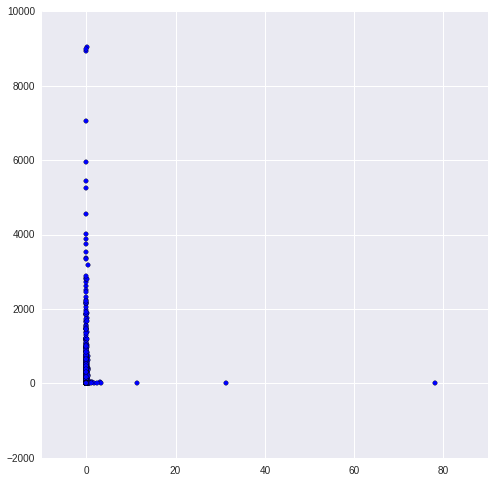

In [31]:
#now plot for each sample for each gene the normalized binding value and the fpkm.
fig = plt.figure(figsize=(8,8),edgecolor='black')
ax = plt.gca()
plt.scatter(combined_df.hnM_DMSO_clip_gene_length_normalized,combined_df.twist_d0_fpkm)


In [46]:
print(len(combined_df))
print(len(gene_cutoff))
print(len(binding_cutoff))

10205
10205
9177


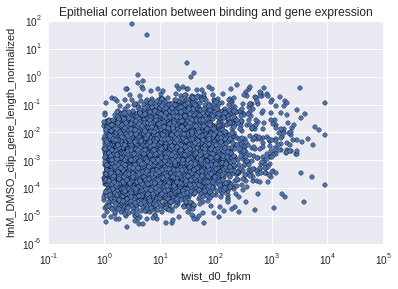

In [61]:
#DMSO correlation between binding and gene expression

#Choose genes for which there is FPKM > 1 and binding > 0
gene_cutoff = combined_df[combined_df.twist_d0_fpkm >= 1]
#binding cutoff = only those that are bound by 
binding_cutoff = gene_cutoff[gene_cutoff.hnM_DMSO_clip_gene_length_normalized > 0]
binding_cutoff.plot(kind='scatter',y='hnM_DMSO_clip_gene_length_normalized',x='twist_d0_fpkm',loglog=True,title='Epithelial correlation between binding and gene expression')

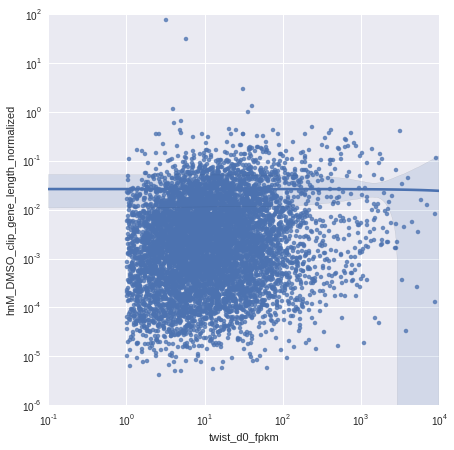

In [66]:
#Trying to do linear regression

f, ax = plt.subplots(figsize=(7,7))
ax.set(xscale="log",yscale="log")
sns.regplot(binding_cutoff.twist_d0_fpkm,binding_cutoff.hnM_DMSO_clip_gene_length_normalized)


# f, ax = plt.subplots(figsize=(7, 7))
# ax.set(xscale="log", yscale="log")
# sns.regplot("x", "y", data, ax=ax, scatter_kws={"s": 100})

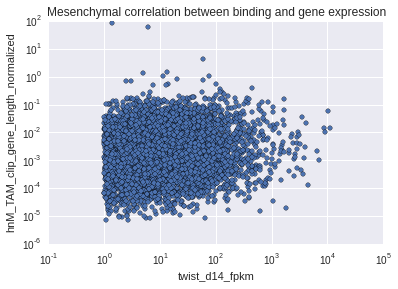

In [56]:
#TAM correlation between binding and gene expression

#Choose genes for which there is FPKM > 1 and binding > 0
gene_cutoff = combined_df[combined_df.twist_d14_fpkm >= 1]
#binding cutoff = only those that are bound by 
binding_cutoff = gene_cutoff[gene_cutoff.hnM_TAM_clip_gene_length_normalized > 0]
binding_cutoff.plot(kind='scatter',y='hnM_TAM_clip_gene_length_normalized',x='twist_d14_fpkm',loglog=True,title='Mesenchymal correlation between binding and gene expression')